In [71]:
import ticktack                 # For the compilation of the model
import ode                      # As a method of solving the odes
import numpy as np              # For the basic functions that need to be written
from jax import numpy as jnp    # annoying shit that I wish I didn't hav to deal with 
import jax.experimental.ode as jax  # Jax odeint 
import pandas as pd             # Becuase I want to 
from time import process_time   # For timing the different ode implementations
import matplotlib.pyplot as plt # Plotting library for visualisations
plt.style.use("dark_background")# Because dark mpde

In [72]:
parameters = np.zeros(6)            # Empty array to hold the parameters of the prodcution function 
parameters[0] = 7.044873503263437   # Mean of the sinusoidal production 
parameters[1] = 0.18                # Amplitude of the sinusoidal production 
parameters[2] = 11.0                # Period of the sinusoidal production 
parameters[3] = 1.25                # Phase of the sinusoidal production 
parameters[4] = 120.05769867244142  # Height of the super-gaussian 
parameters[5] = 12.0                # Width of the super-gaussian 

In [73]:
projection = np.zeros(11)   # An array to hold the projection of the production function 
projection[0] = 0.7         # Proportion projection into the stratosphere       
projection[1] = 0.3         # Proportion projection into the troposphere

In [74]:
def production(t):    
    """
    The production function defined as the sum of sinusoidal and super-gaussian terms 
    """
    return parameters[0] * (1 + parameters[1] * \
        jnp.sin(2 * jnp.pi / parameters[2] * t + parameters[3])) + \
        parameters[4] * jnp.exp(- (parameters[5] * (t - 775)) ** 16)

In [75]:
cbm = ticktack.load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
cbm.compile()   # Constructing the transfer operator 

In [6]:
#! Finish commenting this cell
u0 = np.zeros(11)   # Housing the initial C14 concentrations 
u0[0] = 135.76261605786132  # Initial stratosphere concentration
u0[1] = 709.7591911307035   # Initial troposphere concentration
u0[2] = 1191.489526709938   # Initial surface ocean concentration
u0[3] = 3.97158546945107    # Initial ocean biosphere concentration 
u0[4] = 45158.65854589925
u0[5] = 155.54703228960028
u0[6] = 634.290736403387
u0[7] = 423.5954241095565
u0[8] = 1808.3343542055652
u0[9] = 665.933052175064
u0[10] = 7348.751626918585  

In [7]:
def dydx(y, t):
    """
    The gradient of the carbon box model.
    """
    return cbm._matrix @ y + production(t) * projection

This is going very very well. I need to go plumbing again though. this means that I can look through the depths of the ode implementation and destroy the extra return improving my ability to do things

So I want to only use jax numpy and transition to using lax. Next priority though is to write the loss function and to differentiate it. I also need a bin function 

I need to explain the cheet codes that I am using to simplify the process for the profiling 

I need to generate a visual since the is an insane chi squared.

In [64]:
def loss_function(odeint, args):
    simulation = odeint(*args)[:, 2][0:28]  # Running the simulation 

    miyake = pd.read_csv("Miyake12.csv", sep=" ")   # Importing the miyake data
    simulation += np.mean(miyake.d14c[1:4])         # Adding the offset 
    return - 0.5 * np.sum(((miyake.d14c - simulation) / miyake.sig_d14c) ** 2)

In [65]:
loss_function(ode.odeint, [dydx, u0, np.arange(760.0, 790.0)])

-7413665.688287802

In [49]:
results = {    # Storing the data using a dictionary 
    "solver" : [],              # The library containing the solver 
    "function" : [],            # The function that was getting profiled 
    "time" : [],                # The mean run time of 10 trials 
    "time variance" : []       # The variance of the run time of 10 trials
}

def profile(func, args=[]) -> tuple:
    time_sample = np.zeros(10)  # Storing the trials
    
    for i in range(10):
        timer = process_time()                  # starting a timer 
        func(*args)                             # Running the model 
        time_sample[i] = process_time() - timer # Stopping the timer and storing 

    return np.mean(time_sample), np.var(time_sample)

namespaces = {ode : "ode", jax : "jax"} # For translation from string to module 

for namespace in namespaces:# Iterating through the namespaces of odeint function 
    mean, variance = profile(
        namespace.odeint, [dydx, u0, np.arange(760.0, 790.0)])   # Profiling the speed

    results["function"].append("odeint")            # The function that was profiled 
    results["solver"].append(namespaces[namespace]) # Stroing implementation 
    results["time"].append(mean)                    # Storing the mean run time 
    results["time variance"].append(variance)       # Storing the variance of the mean

    mean, variance = profile()
    


In [50]:
results = pd.DataFrame(results) # Switching to a pandas data frame
results

,solver,function,time,time variance
0,ode,odeint,0.001167,1.671979e-07
1,jax,odeint,0.000735,3.983242e-08


In [45]:
from jax import jvp, grad
import jax.numpy as np

jvp(np.sin, (np.pi,), (1.0,))
# cos = grad(np.sin)
# cos(3.14159)

(DeviceArray(1.2246468e-16, dtype=float64, weak_type=True),
 DeviceArray(-1., dtype=float64, weak_type=True))

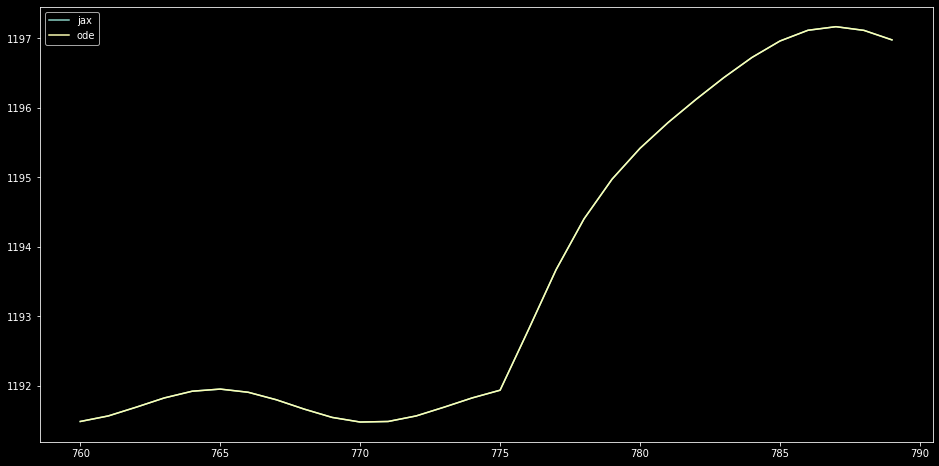

In [69]:
time_space = np.arange(760.0, 790.0)    # times of the sampling 

jax_solution = jax.odeint(dydx, u0, np.arange(760.0, 790.0))[:, 2]
ode_solution = ode.odeint(dydx, u0, np.arange(760.0, 790.0))[:, 2]

plt.figure("C14 Concentration")
plt.plot(time_space, jax_solution, label="jax") # Plotting the entire data 
plt.plot(time_space, ode_solution, label="ode")
plt.legend()
plt.show()                      # Showing the plot 